# Ranking on undirected graphs

Here we check the ranking for undirected graphs, such as, the path graphs, cycle graphs, star graphs, wheel graphs, comlete graph, balanced tree, and barbell graph. 

## Programs

These programs are collected from the file "Ranking on nodes directed graph with damping factor.ipynb". Check that file for detailed description.

In [1]:
import math as math
import networkx as nx
import matplotlib.pyplot as plt
import scipy.linalg as lin
import numpy as np
import sympy as sym
from networkx.drawing.nx_pydot import graphviz_layout

In [2]:
pi = np.pi

In [3]:
def ket_vector(n, v):
    ket = [0] * n
    ket[v] = 1
    return np.matrix(ket).transpose()

In [4]:
def w_coeff(n, u_0, k):
    return(np.exp(2J*pi * u_0 * k / n))

In [5]:
def Weyl(n, u_0, u_l):
    z = np.matrix(np.zeros((n ,n)))
    for k in range(n):
        w = w_coeff(n, u_0, k)
        z = z + w * ket_vector(n, k) * ket_vector(n, (k + u_l) % n).transpose()
    return(z)

In [6]:
def make_directed(G):
    V = list(G.nodes())
    Vdict = {}
    for v in V:
        E = [(v, v)]
        for u in G.neighbors(v):
            E.append((v,u))
        Vdict[v] = E
    return(Vdict)

In [7]:
def Kraus_dictionary(G):
    n = G.order()
    Kdict = {}
    if type(G) == nx.classes.graph.Graph:
        G = G.to_directed()
    for u_0 in list(G.nodes()):
        d = G.out_degree(u_0) + 1
        Kdict[(u_0, u_0)] = np.matrix(np.eye(n))/math.sqrt(d)
        for u_l in G.neighbors(u_0):
            Kdict[(u_0, u_l)] = Weyl(n, u_0, u_l)/math.sqrt(d)
    return(Kdict)

In [8]:
def initial_state(G):
    n = G.order()
    I = np.matrix(np.eye(n))
    list_of_density_matrices = [I/n**2]*n
    return(list_of_density_matrices)

In [9]:
def evolve(G, IS, T):
    n = G.order()
    V = list(G.nodes())
    M = IS.copy()
    Kdict = Kraus_dictionary(G)
    for t in range(0, T):
#         print("t = ", t)
        L = [np.matrix(np.zeros((n , n)))]*n
        for i in range(n):
            u_0 = V[i]
            E = []
            E = list(G.in_edges(u_0)) + [(u_0, u_0)]
            for e in E:
                L[i] = L[i] + Kdict[e] * M[e[0]] * np.conjugate(Kdict[e]).transpose()
        P = []
        for i in range(n):
            M[i] = L[i]
            P.append(np.around(np.trace(M[i]), 4))
#         print(P)
    dic = {}
    for i in range(n):
        dic[i] = P[i]
    return(dic)

In [10]:
def evolve_with_damping(G, IS, T, alpha):
    n = G.order()
    V = list(G.nodes())
    M = IS.copy()
    Kdict = Kraus_dictionary(G)
    for t in range(0, T):
#         print("t = ", t)
        L = [np.matrix(np.zeros((n , n)))]*n
        for i in range(n):
            u_0 = V[i]
            E = []
            E = list(G.in_edges(u_0)) + [(u_0, u_0)]
            for e in E:
                L[i] = L[i] + Kdict[e] * M[e[0]] * np.conjugate(Kdict[e]).transpose()
        P = []
        Dump = sum(M)
        for i in range(n):
#             M[i] = L[i]
            M[i] = alpha * L[i] + (1 - alpha) * Dump / n
            P.append(np.around(np.trace(M[i]), 4))
#         print(P)
#     dic = {}
#     for i in range(n):
#         dic[i] = P[i]
    return(P)

In [11]:
def one_step_evolution(G, alpha, M):
    n = G.order()
    V = list(G.nodes())
    Kdict = Kraus_dictionary(G)
    L = [np.matrix(np.zeros((n , n)))]*n
    if type(G) == nx.classes.graph.Graph:
        G = G.to_directed()
    for i in range(n):
        u_0 = V[i]
        E = []
        E = list(G.in_edges(u_0)) + [(u_0, u_0)]
        for e in E:
            L[i] = L[i] + Kdict[e] * M[e[0]] * np.conjugate(Kdict[e]).transpose()
    Dump = sum(M)
    for i in range(n):
        L[i] = alpha * L[i] + (1 - alpha) * Dump / n
    return(L)

In [12]:
def find_probability(M):
    n = len(M)
    P = []
    for i in range(n):
        P.append(np.around(np.trace(M[i]), 4))
    return(P)

In [13]:
def q_rank(G, alpha):
    n = G.order()
    V = list(G.nodes())
    Kdict = Kraus_dictionary(G)
    IS = initial_state(G)
    M = IS.copy()
    P = []
    P = find_probability(M)
    Q = [1]*n
    t = 1
    while lin.norm(np.array(P) - np.array(Q)) >= .0001:
        P = []
        P = Q
#         print(P)
        L = one_step_evolution(G, .85, M)
        Q = []
        Q = find_probability(L)
#         print(Q)
        M = []
        M = L.copy()
        t = t + 1
    dic = {}
    for i in range(n):
        dic[i] = np.real(Q[i])
    return(dic, t)

In [14]:
def Google_matrix(G, alpha):
    n = G.order()
    if type(G) == nx.classes.graph.Graph:
        G = G.to_directed()
    O = np.ones(n)
    A = nx.adjacency_matrix(G).A
    S = np.zeros((n, n))
    for i in range(n):
        if G.out_degree(i) != 0:
            d = G.out_degree(i)
            S[i] = A[i]/d
        else:
            S[i] = np.ones(n)/n
    Google = alpha * S + (1 - alpha)*O/n
    return(Google)

In [15]:
def page_rank(G, alpha):
    Google = np.matrix(Google_matrix(G, alpha))
    n = G.order()
    w = np.ones(n) / n
    v = w*Google
    t = 1
    while np.linalg.norm(w - v) >= .0001:
        w = v
        v = w*Google
        t = t + 1
    dic = {}
    v = np.array(v)[0]
    for i in range(n):
        dic[i] = v[i]
    return(dic, t)
#     return(v)

## Examples on undirected graphs

### Path graph

In [16]:
G = nx.path_graph(10)

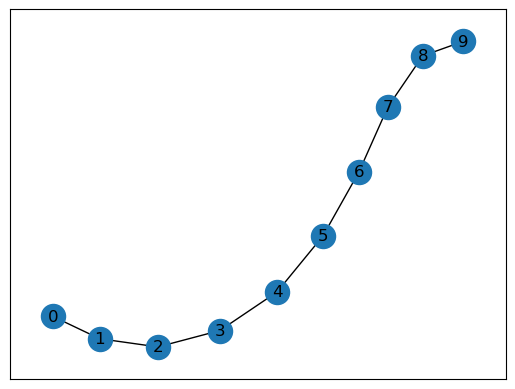

In [17]:
nx.draw_networkx(G)

In [18]:
P = nx.pagerank(G)
for key in P.keys():
    P[key] = round(P[key], 4)
P

{0: 0.0644,
 1: 0.1162,
 2: 0.1093,
 3: 0.1058,
 4: 0.1043,
 5: 0.1043,
 6: 0.1058,
 7: 0.1093,
 8: 0.1162,
 9: 0.0644}

In [19]:
Q, t = q_rank(G, .8)
Q

{0: 0.0804,
 1: 0.1102,
 2: 0.1051,
 3: 0.1027,
 4: 0.1017,
 5: 0.1017,
 6: 0.1027,
 7: 0.1051,
 8: 0.1102,
 9: 0.0804}

In [20]:
P1 = np.real(list(P.values()))
P1

array([0.0644, 0.1162, 0.1093, 0.1058, 0.1043, 0.1043, 0.1058, 0.1093,
       0.1162, 0.0644])

In [21]:
Q1 = np.real(list(Q.values()))
Q1

array([0.0804, 0.1102, 0.1051, 0.1027, 0.1017, 0.1017, 0.1027, 0.1051,
       0.1102, 0.0804])

In [22]:
X = list(G.nodes())
X

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

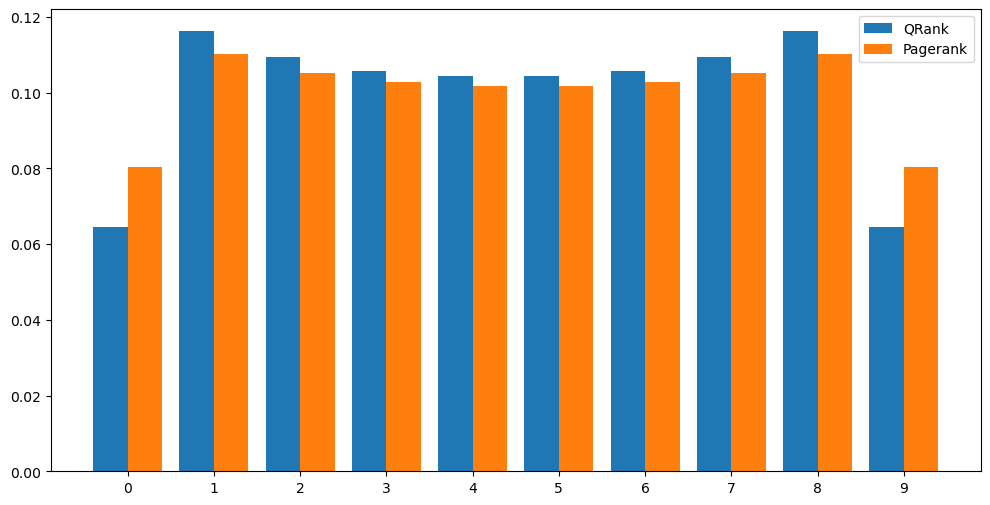

In [23]:
plt.figure(figsize=(12,6))
X_axis = np.arange(len(X))
plt.bar(X_axis - 0.2, P1, 0.4, label = 'QRank') 
plt.bar(X_axis + 0.2, Q1, 0.4, label = 'Pagerank')
plt.xticks(X_axis, X) 
plt.legend() 
plt.show() 

### Cycle graph

In [24]:
G = nx.cycle_graph(20)

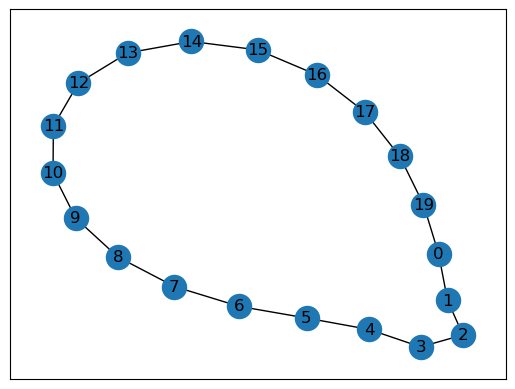

In [25]:
nx.draw_networkx(G)

In [26]:
P, t = page_rank(G, .8)
P

/tmp/ipykernel_20046/3751517394.py:6: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G).A


{0: 0.05,
 1: 0.05000000000000002,
 2: 0.05000000000000002,
 3: 0.05000000000000002,
 4: 0.05000000000000002,
 5: 0.05000000000000002,
 6: 0.05000000000000002,
 7: 0.05000000000000001,
 8: 0.05000000000000001,
 9: 0.05000000000000001,
 10: 0.05000000000000001,
 11: 0.05000000000000001,
 12: 0.05000000000000001,
 13: 0.05000000000000001,
 14: 0.05000000000000001,
 15: 0.05,
 16: 0.05,
 17: 0.05000000000000001,
 18: 0.05000000000000001,
 19: 0.05}

In [27]:
t

1

In [28]:
Q, t = q_rank(G, .8)
Q

{0: 0.05,
 1: 0.05,
 2: 0.05,
 3: 0.05,
 4: 0.05,
 5: 0.05,
 6: 0.05,
 7: 0.05,
 8: 0.05,
 9: 0.05,
 10: 0.05,
 11: 0.05,
 12: 0.05,
 13: 0.05,
 14: 0.05,
 15: 0.05,
 16: 0.05,
 17: 0.05,
 18: 0.05,
 19: 0.05}

In [29]:
t

3

In [30]:
P1 = np.real(list(P.values()))
P1

array([0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05,
       0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05])

In [31]:
Q1 = np.real(list(Q.values()))
Q1

array([0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05,
       0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05])

In [32]:
X = list(G.nodes())
X

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]

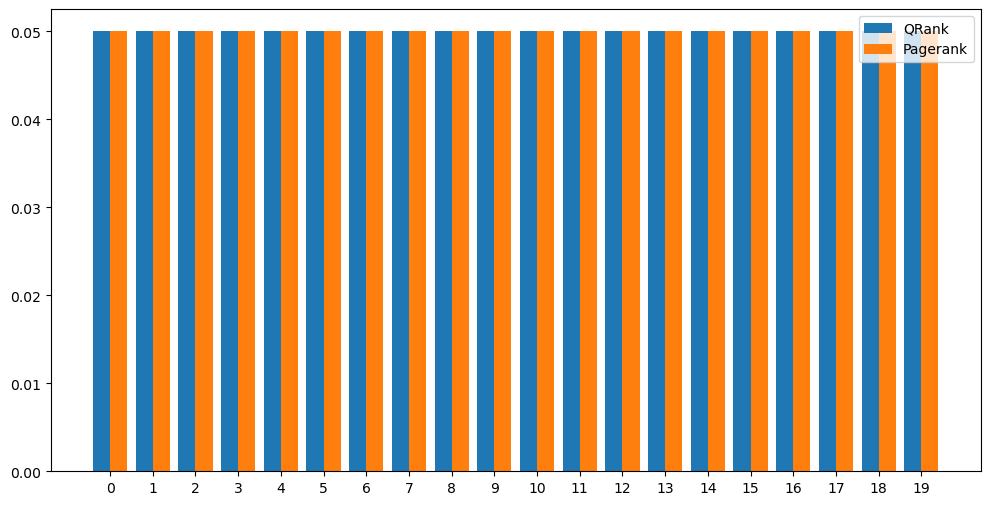

In [33]:
plt.figure(figsize=(12,6))
X_axis = np.arange(len(X))
plt.bar(X_axis - 0.2, P1, 0.4, label = 'QRank') 
plt.bar(X_axis + 0.2, Q1, 0.4, label = 'Pagerank')
plt.xticks(X_axis, X) 
plt.legend() 
plt.show() 

### Star graph

In [34]:
G = nx.star_graph(20)

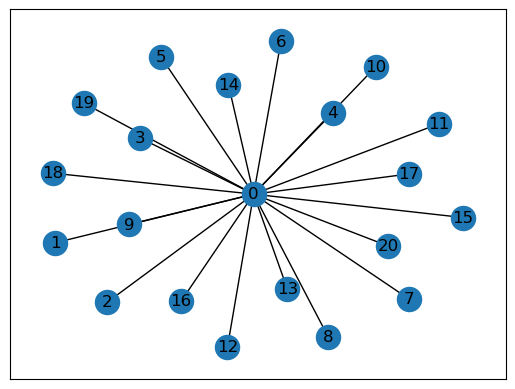

In [35]:
nx.draw_networkx(G)

In [36]:
P, t = page_rank(G, .8)
P

/tmp/ipykernel_20046/3751517394.py:6: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G).A


{0: 0.4497782100857901,
 1: 0.027511089495710458,
 2: 0.027511089495710458,
 3: 0.027511089495710458,
 4: 0.027511089495710458,
 5: 0.027511089495710458,
 6: 0.027511089495710458,
 7: 0.027511089495710458,
 8: 0.027511089495710458,
 9: 0.027511089495710458,
 10: 0.027511089495710458,
 11: 0.027511089495710458,
 12: 0.027511089495710458,
 13: 0.027511089495710458,
 14: 0.027511089495710458,
 15: 0.027511089495710458,
 16: 0.027511089495710458,
 17: 0.027511089495710458,
 18: 0.027511089495710458,
 19: 0.027511089495710458,
 20: 0.02751108949571049}

In [37]:
t

41

In [38]:
Q, t = q_rank(G, .8)
Q

{0: 0.3121,
 1: 0.0344,
 2: 0.0344,
 3: 0.0344,
 4: 0.0344,
 5: 0.0344,
 6: 0.0344,
 7: 0.0344,
 8: 0.0344,
 9: 0.0344,
 10: 0.0344,
 11: 0.0344,
 12: 0.0344,
 13: 0.0344,
 14: 0.0344,
 15: 0.0344,
 16: 0.0344,
 17: 0.0344,
 18: 0.0344,
 19: 0.0344,
 20: 0.0344}

In [39]:
t

11

In [40]:
P1 = np.real(list(P.values()))
P1

array([0.44977821, 0.02751109, 0.02751109, 0.02751109, 0.02751109,
       0.02751109, 0.02751109, 0.02751109, 0.02751109, 0.02751109,
       0.02751109, 0.02751109, 0.02751109, 0.02751109, 0.02751109,
       0.02751109, 0.02751109, 0.02751109, 0.02751109, 0.02751109,
       0.02751109])

In [41]:
Q1 = np.real(list(Q.values()))
Q1

array([0.3121, 0.0344, 0.0344, 0.0344, 0.0344, 0.0344, 0.0344, 0.0344,
       0.0344, 0.0344, 0.0344, 0.0344, 0.0344, 0.0344, 0.0344, 0.0344,
       0.0344, 0.0344, 0.0344, 0.0344, 0.0344])

In [42]:
X = list(G.nodes())
X

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]

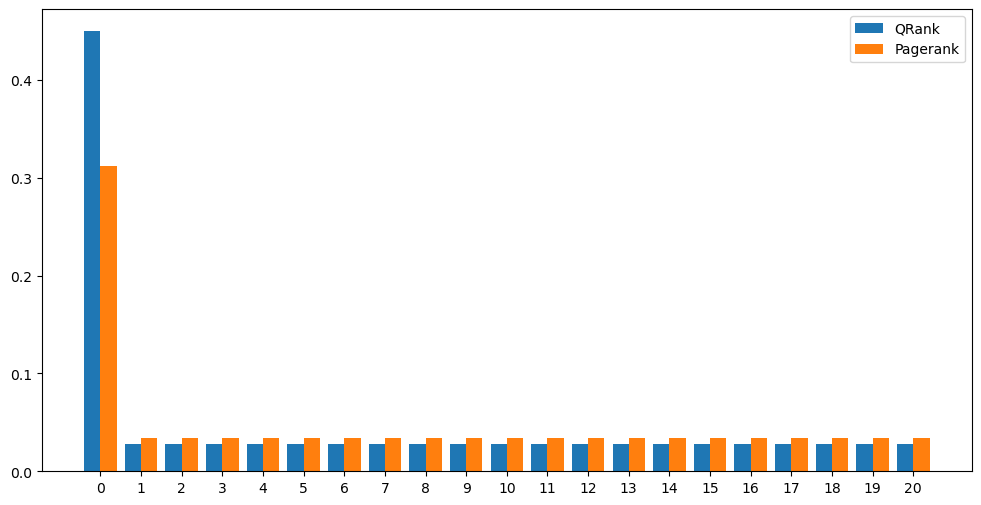

In [43]:
plt.figure(figsize=(12,6))
X_axis = np.arange(len(X))
plt.bar(X_axis - 0.2, P1, 0.4, label = 'QRank') 
plt.bar(X_axis + 0.2, Q1, 0.4, label = 'Pagerank')
plt.xticks(X_axis, X) 
plt.legend() 
plt.show() 

### Wheel graph

In [44]:
G = nx.wheel_graph(20)

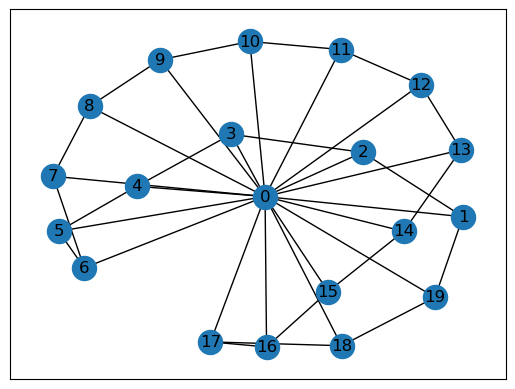

In [45]:
nx.draw_networkx(G)

In [46]:
P, t = page_rank(G, .8)
P

/tmp/ipykernel_20046/3751517394.py:6: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G).A


{0: 0.21843720281664378,
 1: 0.0411348840622819,
 2: 0.0411348840622819,
 3: 0.0411348840622819,
 4: 0.0411348840622819,
 5: 0.04113488406228189,
 6: 0.04113488406228189,
 7: 0.0411348840622819,
 8: 0.0411348840622819,
 9: 0.0411348840622819,
 10: 0.0411348840622819,
 11: 0.0411348840622819,
 12: 0.0411348840622819,
 13: 0.0411348840622819,
 14: 0.0411348840622819,
 15: 0.0411348840622819,
 16: 0.0411348840622819,
 17: 0.0411348840622819,
 18: 0.0411348840622819,
 19: 0.0411348840622819}

In [47]:
t

7

In [48]:
Q, t = q_rank(G, .8)
Q

{0: 0.188,
 1: 0.0427,
 2: 0.0427,
 3: 0.0427,
 4: 0.0427,
 5: 0.0427,
 6: 0.0427,
 7: 0.0427,
 8: 0.0427,
 9: 0.0427,
 10: 0.0427,
 11: 0.0427,
 12: 0.0427,
 13: 0.0427,
 14: 0.0427,
 15: 0.0427,
 16: 0.0427,
 17: 0.0427,
 18: 0.0427,
 19: 0.0427}

In [49]:
t

7

In [50]:
P1 = np.real(list(P.values()))
P1

array([0.2184372 , 0.04113488, 0.04113488, 0.04113488, 0.04113488,
       0.04113488, 0.04113488, 0.04113488, 0.04113488, 0.04113488,
       0.04113488, 0.04113488, 0.04113488, 0.04113488, 0.04113488,
       0.04113488, 0.04113488, 0.04113488, 0.04113488, 0.04113488])

In [51]:
Q1 = np.real(list(Q.values()))
Q1

array([0.188 , 0.0427, 0.0427, 0.0427, 0.0427, 0.0427, 0.0427, 0.0427,
       0.0427, 0.0427, 0.0427, 0.0427, 0.0427, 0.0427, 0.0427, 0.0427,
       0.0427, 0.0427, 0.0427, 0.0427])

In [52]:
X = list(G.nodes())
X

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]

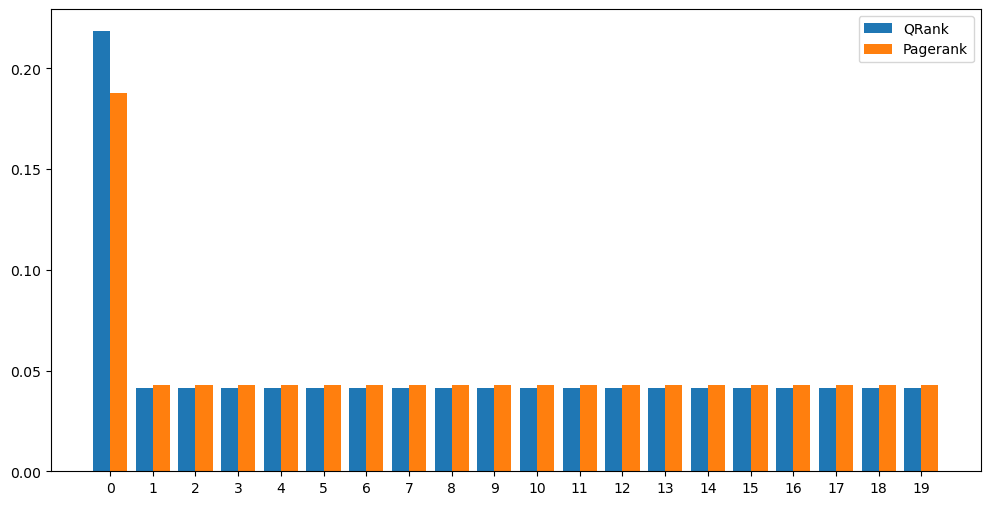

In [53]:
plt.figure(figsize=(12,6))
X_axis = np.arange(len(X))
plt.bar(X_axis - 0.2, P1, 0.4, label = 'QRank') 
plt.bar(X_axis + 0.2, Q1, 0.4, label = 'Pagerank')
plt.xticks(X_axis, X) 
plt.legend() 
plt.show() 

### Complete graph

In [54]:
G = nx.complete_graph(20)

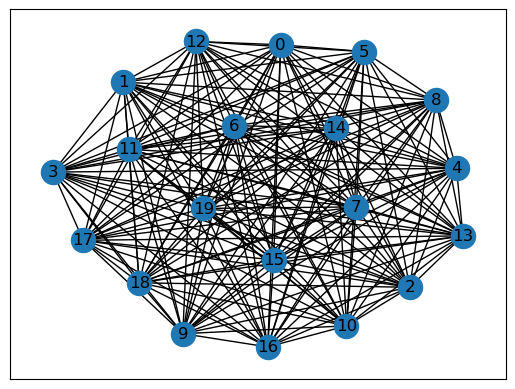

In [55]:
nx.draw_networkx(G)

In [56]:
P, t = page_rank(G, .8)
P

/tmp/ipykernel_20046/3751517394.py:6: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G).A


{0: 0.05000000000000001,
 1: 0.05000000000000001,
 2: 0.05000000000000001,
 3: 0.05000000000000001,
 4: 0.05000000000000001,
 5: 0.05000000000000001,
 6: 0.05000000000000001,
 7: 0.05000000000000001,
 8: 0.05000000000000001,
 9: 0.05000000000000001,
 10: 0.05000000000000001,
 11: 0.05000000000000001,
 12: 0.05000000000000001,
 13: 0.05000000000000001,
 14: 0.05000000000000001,
 15: 0.05000000000000001,
 16: 0.05,
 17: 0.05,
 18: 0.05000000000000001,
 19: 0.05000000000000001}

In [57]:
t

1

In [58]:
Q, t = q_rank(G, .8)
Q

{0: 0.05,
 1: 0.05,
 2: 0.05,
 3: 0.05,
 4: 0.05,
 5: 0.05,
 6: 0.05,
 7: 0.05,
 8: 0.05,
 9: 0.05,
 10: 0.05,
 11: 0.05,
 12: 0.05,
 13: 0.05,
 14: 0.05,
 15: 0.05,
 16: 0.05,
 17: 0.05,
 18: 0.05,
 19: 0.05}

In [59]:
t

3

In [60]:
P1 = np.real(list(P.values()))
P1

array([0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05,
       0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05])

In [61]:
Q1 = np.real(list(Q.values()))
Q1

array([0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05,
       0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05])

In [62]:
X = list(G.nodes())
X

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]

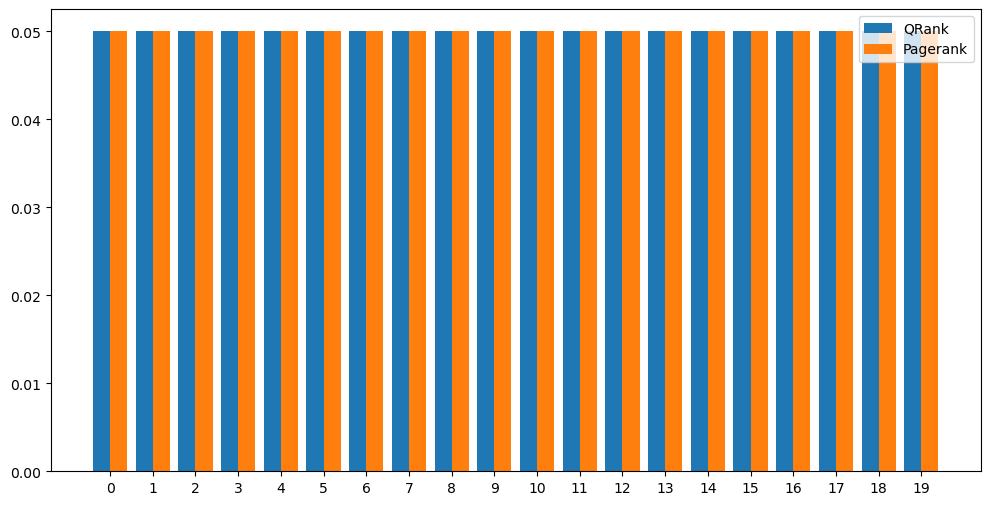

In [63]:
plt.figure(figsize=(12,6))
X_axis = np.arange(len(X))
plt.bar(X_axis - 0.2, P1, 0.4, label = 'QRank') 
plt.bar(X_axis + 0.2, Q1, 0.4, label = 'Pagerank')
plt.xticks(X_axis, X) 
plt.legend() 
plt.show() 

### Balanced Tree

In [64]:
G = nx.balanced_tree(3,3)

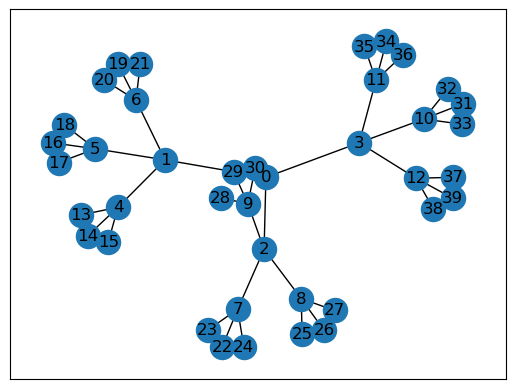

In [65]:
nx.draw_networkx(G)

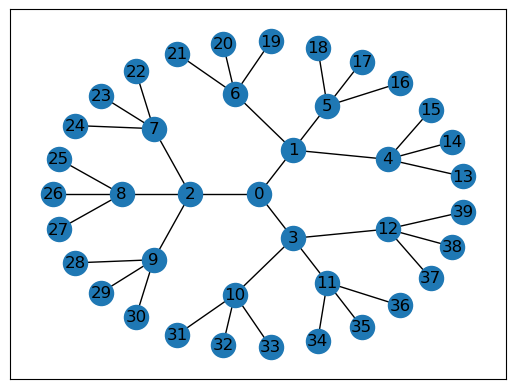

In [66]:
pos = graphviz_layout(G, prog="twopi")
nx.draw_networkx(G, pos)
plt.show()

In [67]:
P, t = page_rank(G, .8)
P

/tmp/ipykernel_20046/3751517394.py:6: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G).A


{0: 0.030546887859143772,
 1: 0.0426041495211417,
 2: 0.04260414952114171,
 3: 0.04260414952114171,
 4: 0.04906251714552502,
 5: 0.04906251714552502,
 6: 0.04906251714552502,
 7: 0.04906251714552502,
 8: 0.04906251714552502,
 9: 0.04906251714552502,
 10: 0.04906251714552503,
 11: 0.04906251714552502,
 12: 0.04906251714552502,
 13: 0.01481770404695209,
 14: 0.01481770404695209,
 15: 0.01481770404695209,
 16: 0.014817704046952094,
 17: 0.014817704046952094,
 18: 0.014817704046952094,
 19: 0.014817704046952094,
 20: 0.014817704046952094,
 21: 0.014817704046952094,
 22: 0.014817704046952094,
 23: 0.014817704046952094,
 24: 0.014817704046952094,
 25: 0.014817704046952093,
 26: 0.014817704046952093,
 27: 0.014817704046952093,
 28: 0.014817704046952094,
 29: 0.014817704046952094,
 30: 0.014817704046952094,
 31: 0.014817704046952093,
 32: 0.014817704046952093,
 33: 0.014817704046952093,
 34: 0.014817704046952094,
 35: 0.014817704046952094,
 36: 0.014817704046952094,
 37: 0.014817704046952098,


In [68]:
t

34

In [69]:
Q, t = q_rank(G, .8)
Q

{0: 0.0284,
 1: 0.0366,
 2: 0.0366,
 3: 0.0366,
 4: 0.0404,
 5: 0.0404,
 6: 0.0404,
 7: 0.0404,
 8: 0.0404,
 9: 0.0404,
 10: 0.0404,
 11: 0.0404,
 12: 0.0404,
 13: 0.0185,
 14: 0.0185,
 15: 0.0185,
 16: 0.0185,
 17: 0.0185,
 18: 0.0185,
 19: 0.0185,
 20: 0.0185,
 21: 0.0185,
 22: 0.0185,
 23: 0.0185,
 24: 0.0185,
 25: 0.0185,
 26: 0.0185,
 27: 0.0185,
 28: 0.0185,
 29: 0.0185,
 30: 0.0185,
 31: 0.0185,
 32: 0.0185,
 33: 0.0185,
 34: 0.0185,
 35: 0.0185,
 36: 0.0185,
 37: 0.0185,
 38: 0.0185,
 39: 0.0185}

In [70]:
t

10

In [71]:
P1 = np.real(list(P.values()))
P1

array([0.03054689, 0.04260415, 0.04260415, 0.04260415, 0.04906252,
       0.04906252, 0.04906252, 0.04906252, 0.04906252, 0.04906252,
       0.04906252, 0.04906252, 0.04906252, 0.0148177 , 0.0148177 ,
       0.0148177 , 0.0148177 , 0.0148177 , 0.0148177 , 0.0148177 ,
       0.0148177 , 0.0148177 , 0.0148177 , 0.0148177 , 0.0148177 ,
       0.0148177 , 0.0148177 , 0.0148177 , 0.0148177 , 0.0148177 ,
       0.0148177 , 0.0148177 , 0.0148177 , 0.0148177 , 0.0148177 ,
       0.0148177 , 0.0148177 , 0.0148177 , 0.0148177 , 0.0148177 ])

In [72]:
Q1 = np.real(list(Q.values()))
Q1

array([0.0284, 0.0366, 0.0366, 0.0366, 0.0404, 0.0404, 0.0404, 0.0404,
       0.0404, 0.0404, 0.0404, 0.0404, 0.0404, 0.0185, 0.0185, 0.0185,
       0.0185, 0.0185, 0.0185, 0.0185, 0.0185, 0.0185, 0.0185, 0.0185,
       0.0185, 0.0185, 0.0185, 0.0185, 0.0185, 0.0185, 0.0185, 0.0185,
       0.0185, 0.0185, 0.0185, 0.0185, 0.0185, 0.0185, 0.0185, 0.0185])

In [73]:
X = list(G.nodes())
X

[0,
 1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 25,
 26,
 27,
 28,
 29,
 30,
 31,
 32,
 33,
 34,
 35,
 36,
 37,
 38,
 39]

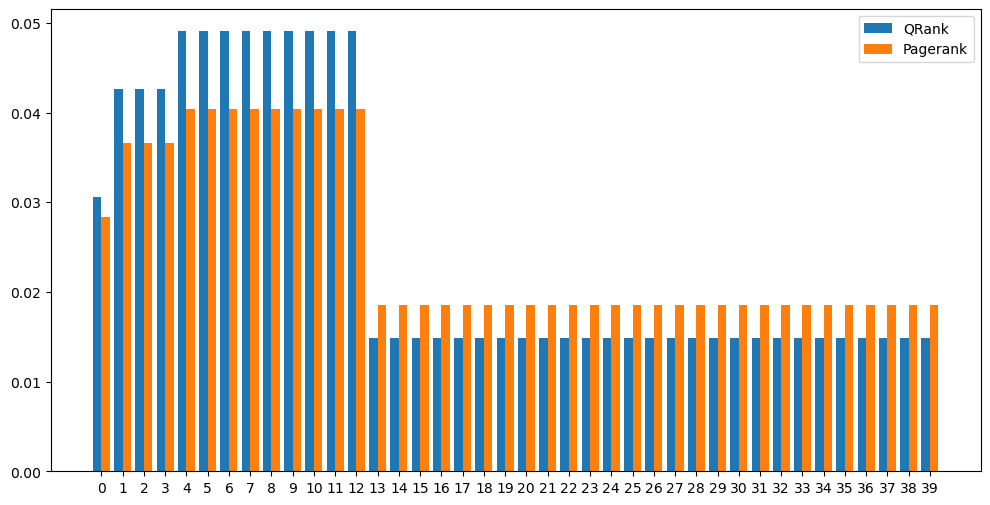

In [74]:
plt.figure(figsize=(12,6))
X_axis = np.arange(len(X))
plt.bar(X_axis - 0.2, P1, 0.4, label = 'QRank') 
plt.bar(X_axis + 0.2, Q1, 0.4, label = 'Pagerank')
plt.xticks(X_axis, X) 
plt.legend() 
plt.show() 

### Barbell Graph

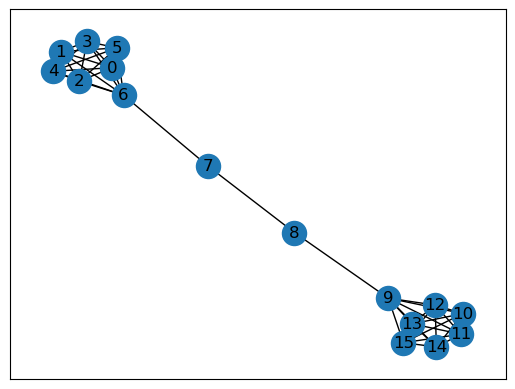

In [75]:
G = nx.barbell_graph(7,2)
nx.draw_networkx(G)

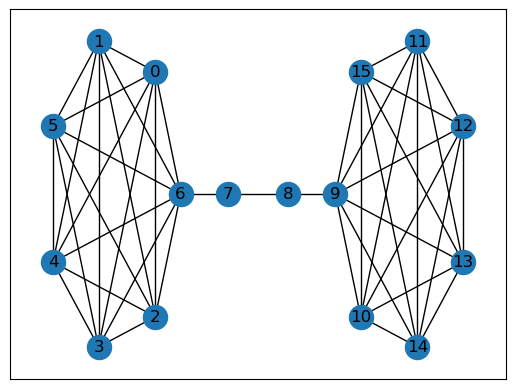

In [76]:
pos = graphviz_layout(G, prog="circo")
nx.draw_networkx(G, pos)
plt.show()

Our PageRank program fails to find the PageRank of the Barbell graph. We use the library function for calculating PageRank available in Networkx.

In [77]:
P, t = page_rank(G, .8)
P

/tmp/ipykernel_20046/3751517394.py:6: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G).A


{0: 0.06432364766746768,
 1: 0.06432364766746768,
 2: 0.06432364766746768,
 3: 0.06432364766746768,
 4: 0.06432364766746768,
 5: 0.06432364766746768,
 6: 0.07827970649287834,
 7: 0.035778407502315264,
 8: 0.035778407502315264,
 9: 0.07827970649287833,
 10: 0.06432364766746768,
 11: 0.06432364766746768,
 12: 0.06432364766746768,
 13: 0.06432364766746768,
 14: 0.06432364766746768,
 15: 0.06432364766746768}

In [78]:
P = nx.pagerank(G)
P

{0: 0.06478714196346358,
 1: 0.06478714196346358,
 2: 0.06478714196346358,
 3: 0.06478714196346358,
 4: 0.06478714196346358,
 5: 0.06478714196346358,
 6: 0.07841212376187823,
 7: 0.032865024457340075,
 8: 0.032865024457340075,
 9: 0.07841212376187826,
 10: 0.06478714196346358,
 11: 0.06478714196346358,
 12: 0.06478714196346358,
 13: 0.06478714196346358,
 14: 0.06478714196346358,
 15: 0.06478714196346358}

In [79]:
P = dict(sorted(P.items()))
P

{0: 0.06478714196346358,
 1: 0.06478714196346358,
 2: 0.06478714196346358,
 3: 0.06478714196346358,
 4: 0.06478714196346358,
 5: 0.06478714196346358,
 6: 0.07841212376187823,
 7: 0.032865024457340075,
 8: 0.032865024457340075,
 9: 0.07841212376187826,
 10: 0.06478714196346358,
 11: 0.06478714196346358,
 12: 0.06478714196346358,
 13: 0.06478714196346358,
 14: 0.06478714196346358,
 15: 0.06478714196346358}

In [80]:
Q, t = q_rank(G, .8)
Q

{0: 0.0641,
 1: 0.0641,
 2: 0.0641,
 3: 0.0641,
 4: 0.0641,
 5: 0.0641,
 6: 0.0755,
 7: 0.0402,
 8: 0.0402,
 9: 0.0755,
 10: 0.0641,
 11: 0.0641,
 12: 0.0641,
 13: 0.0641,
 14: 0.0641,
 15: 0.0641}

In [81]:
t

13

In [82]:
P1 = np.real(list(P.values()))
P1

array([0.06478714, 0.06478714, 0.06478714, 0.06478714, 0.06478714,
       0.06478714, 0.07841212, 0.03286502, 0.03286502, 0.07841212,
       0.06478714, 0.06478714, 0.06478714, 0.06478714, 0.06478714,
       0.06478714])

In [83]:
Q1 = np.real(list(Q.values()))
Q1

array([0.0641, 0.0641, 0.0641, 0.0641, 0.0641, 0.0641, 0.0755, 0.0402,
       0.0402, 0.0755, 0.0641, 0.0641, 0.0641, 0.0641, 0.0641, 0.0641])

In [84]:
X = sorted(list(G.nodes()))
X

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]

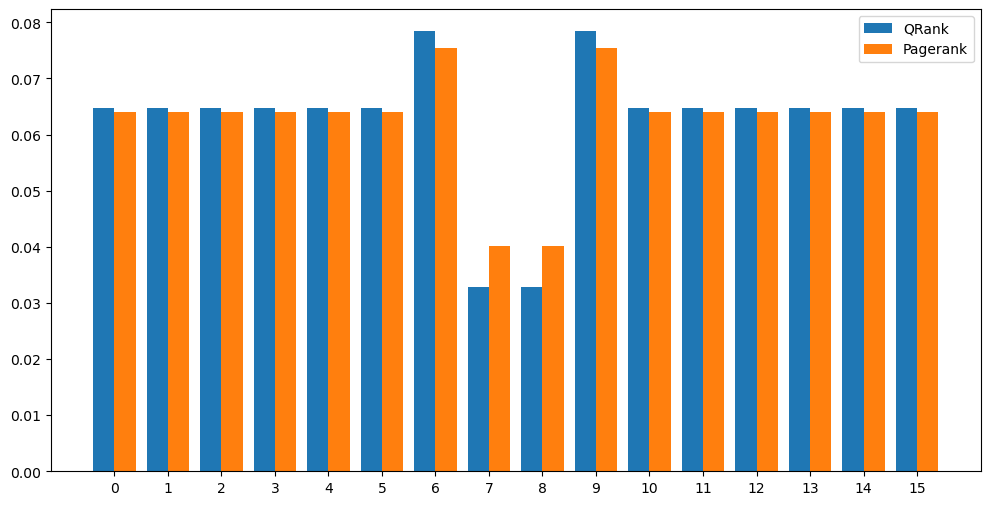

In [85]:
plt.figure(figsize=(12,6))
X_axis = np.arange(len(X))
plt.bar(X_axis - 0.2, P1, 0.4, label = 'QRank') 
plt.bar(X_axis + 0.2, Q1, 0.4, label = 'Pagerank')
plt.xticks(X_axis, X) 
plt.legend() 
plt.show() 

### Watts-Strogatz model

Duncan J. Watts and Steven H. Strogatz, Collective dynamics of small-world networks, Nature, 393, pp. 440–442, 1998.

https://networkx.org/documentation/stable/reference/generated/networkx.generators.random_graphs.watts_strogatz_graph.html

Here the graph may have loops in the vertices. We remove the loops after generating the graph. Also, we calculate the ranks for connected graphs only.

In [86]:
G = nx.watts_strogatz_graph(20, 3, .3, seed=None)
G.remove_edges_from(nx.selfloop_edges(G))

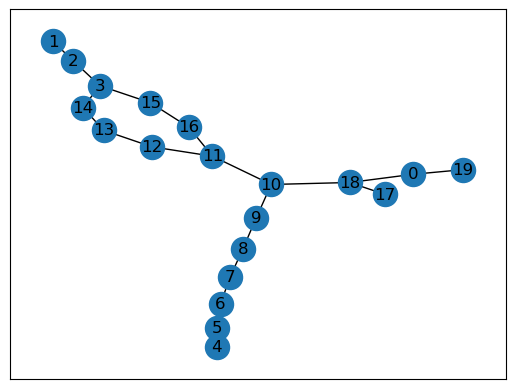

In [87]:
nx.draw_networkx(G)

In [88]:
P, t = page_rank(G, .85)
P

/tmp/ipykernel_20046/3751517394.py:6: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G).A


{0: 0.05451512278924915,
 1: 0.02994140416354935,
 2: 0.052807360972027935,
 3: 0.07007334274717167,
 4: 0.031947569993740786,
 5: 0.057558589607877804,
 6: 0.05381990002520492,
 7: 0.051494891998148135,
 8: 0.04963634640930932,
 9: 0.04770282715195036,
 10: 0.06736974802610979,
 11: 0.06586964148178868,
 12: 0.046280087257316305,
 13: 0.047350485057176435,
 14: 0.04747765260805886,
 15: 0.04695698780165503,
 16: 0.04611184802865975,
 17: 0.02844776733188622,
 18: 0.07396140318648223,
 19: 0.03067702336263752}

In [89]:
t

33

In [90]:
Q, t = q_rank(G, .85)
Q

{0: 0.0529,
 1: 0.0387,
 2: 0.052,
 3: 0.0626,
 4: 0.0401,
 5: 0.0549,
 6: 0.0522,
 7: 0.0506,
 8: 0.0494,
 9: 0.0479,
 10: 0.0603,
 11: 0.0596,
 12: 0.0471,
 13: 0.0481,
 14: 0.048,
 15: 0.0476,
 16: 0.0469,
 17: 0.037,
 18: 0.0648,
 19: 0.0391}

In [91]:
t

15

In [92]:
P1 = np.real(list(P.values()))
P1

array([0.05451512, 0.0299414 , 0.05280736, 0.07007334, 0.03194757,
       0.05755859, 0.0538199 , 0.05149489, 0.04963635, 0.04770283,
       0.06736975, 0.06586964, 0.04628009, 0.04735049, 0.04747765,
       0.04695699, 0.04611185, 0.02844777, 0.0739614 , 0.03067702])

In [93]:
Q1 = np.real(list(Q.values()))
Q1

array([0.0529, 0.0387, 0.052 , 0.0626, 0.0401, 0.0549, 0.0522, 0.0506,
       0.0494, 0.0479, 0.0603, 0.0596, 0.0471, 0.0481, 0.048 , 0.0476,
       0.0469, 0.037 , 0.0648, 0.0391])

In [94]:
X = list(G.nodes())
X

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]

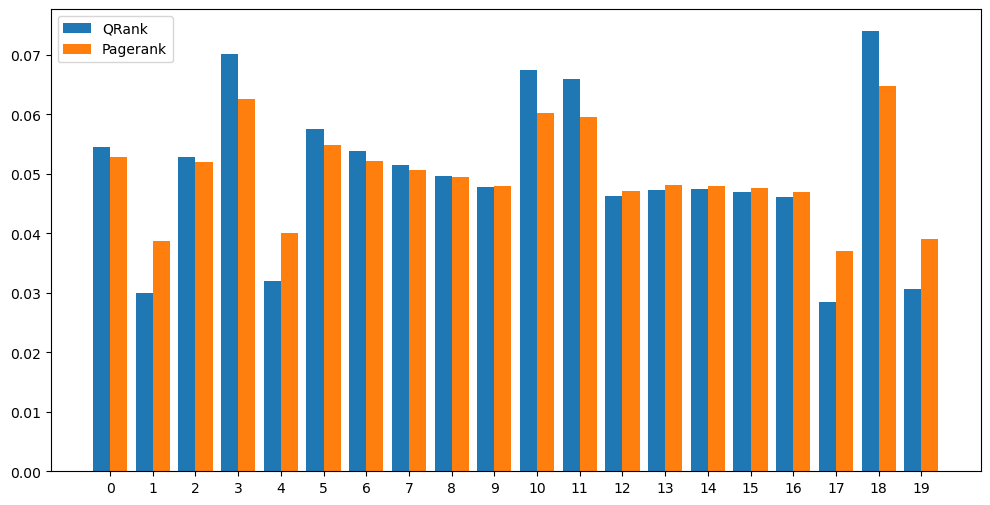

In [95]:
plt.figure(figsize=(12,6))
X_axis = np.arange(len(X))
plt.bar(X_axis - 0.2, P1, 0.4, label = 'QRank') 
plt.bar(X_axis + 0.2, Q1, 0.4, label = 'Pagerank')
plt.xticks(X_axis, X) 
plt.legend() 
plt.show() 

### Karate Club

Zachary W. (1977). An information flow model for conflict and fission in small groups. Journal of Anthropological Research, 33, 452-473.

https://networkx.org/documentation/stable/auto_examples/graph/plot_karate_club.html

In [96]:
G = nx.karate_club_graph()
# G.remove_edges_from(nx.selfloop_edges(G))

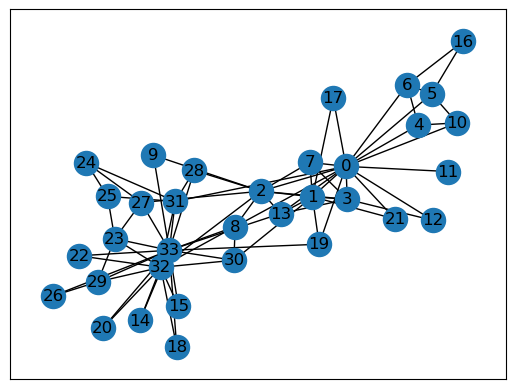

In [97]:
nx.draw_networkx(G)

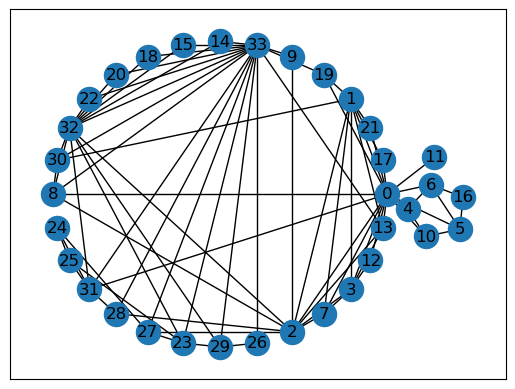

In [98]:
pos = graphviz_layout(G, prog="circo")
nx.draw_networkx(G, pos)
plt.show()

Our program fails to calculate the PageRank. Hence, we use the inbuilt function.

In [99]:
P= nx.pagerank(G, .85)
P

{0: 0.08850807396280012,
 1: 0.057414840497110056,
 2: 0.06276686454603017,
 3: 0.03721208153631377,
 4: 0.020503977347501652,
 5: 0.03381044255357727,
 6: 0.03152901134345504,
 7: 0.026464618678806107,
 8: 0.03338155566846444,
 9: 0.009463219565799959,
 10: 0.020689016083505596,
 11: 0.009785686547904305,
 12: 0.011474872305945287,
 13: 0.033474187085322404,
 14: 0.012941600888556285,
 15: 0.01637633262359366,
 16: 0.016755401561857987,
 17: 0.009677265915396801,
 18: 0.009544864590131914,
 19: 0.013077518431081969,
 20: 0.011224235021037596,
 21: 0.01136015256356328,
 22: 0.01296059860686279,
 23: 0.04114596964602211,
 24: 0.01663437445025268,
 25: 0.028672962013730707,
 26: 0.015240392773380823,
 27: 0.027235358397633882,
 28: 0.01447852177427162,
 29: 0.028271813832825125,
 30: 0.02303184425091186,
 31: 0.04198548926127872,
 32: 0.07592643687005646,
 33: 0.09698041880501741}

In [100]:
Q, t = q_rank(G, .85)
Q

{0: 0.0834,
 1: 0.0479,
 2: 0.0513,
 3: 0.0342,
 4: 0.0236,
 5: 0.0292,
 6: 0.0292,
 7: 0.025,
 8: 0.0292,
 9: 0.0174,
 10: 0.0236,
 11: 0.0149,
 12: 0.0178,
 13: 0.029,
 14: 0.0177,
 15: 0.0177,
 16: 0.02,
 17: 0.0177,
 18: 0.0177,
 19: 0.0213,
 20: 0.0177,
 21: 0.0177,
 22: 0.0177,
 23: 0.0308,
 24: 0.0228,
 25: 0.0228,
 26: 0.0182,
 27: 0.0261,
 28: 0.0213,
 29: 0.0267,
 30: 0.0251,
 31: 0.0353,
 32: 0.0632,
 33: 0.087}

In [101]:
t

15

In [102]:
P1 = np.real(list(P.values()))
P1

array([0.08850807, 0.05741484, 0.06276686, 0.03721208, 0.02050398,
       0.03381044, 0.03152901, 0.02646462, 0.03338156, 0.00946322,
       0.02068902, 0.00978569, 0.01147487, 0.03347419, 0.0129416 ,
       0.01637633, 0.0167554 , 0.00967727, 0.00954486, 0.01307752,
       0.01122424, 0.01136015, 0.0129606 , 0.04114597, 0.01663437,
       0.02867296, 0.01524039, 0.02723536, 0.01447852, 0.02827181,
       0.02303184, 0.04198549, 0.07592644, 0.09698042])

In [103]:
Q1 = np.real(list(Q.values()))
Q1

array([0.0834, 0.0479, 0.0513, 0.0342, 0.0236, 0.0292, 0.0292, 0.025 ,
       0.0292, 0.0174, 0.0236, 0.0149, 0.0178, 0.029 , 0.0177, 0.0177,
       0.02  , 0.0177, 0.0177, 0.0213, 0.0177, 0.0177, 0.0177, 0.0308,
       0.0228, 0.0228, 0.0182, 0.0261, 0.0213, 0.0267, 0.0251, 0.0353,
       0.0632, 0.087 ])

In [104]:
X = list(G.nodes())
X

[0,
 1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 25,
 26,
 27,
 28,
 29,
 30,
 31,
 32,
 33]

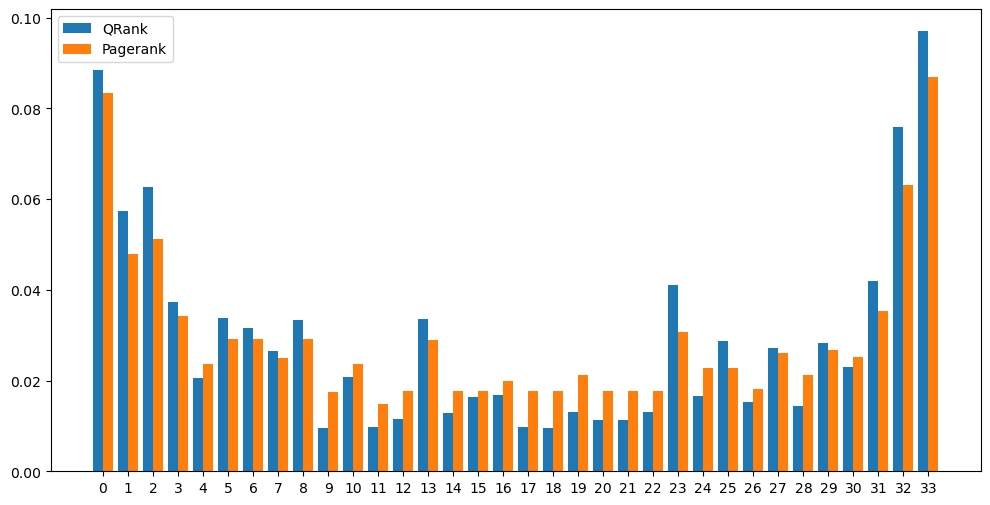

In [105]:
plt.figure(figsize=(12,6))
X_axis = np.arange(len(X))
plt.bar(X_axis - 0.2, P1, 0.4, label = 'QRank') 
plt.bar(X_axis + 0.2, Q1, 0.4, label = 'Pagerank')
plt.xticks(X_axis, X) 
plt.legend() 
plt.show() 

### Barabási and Albert model

A. L. Barabási and R. Albert “Emergence of scaling in random networks”, Science 286, pp 509-512, 1999.

https://networkx.org/documentation/stable/reference/generated/networkx.generators.random_graphs.barabasi_albert_graph.html

In [106]:
G = nx.barabasi_albert_graph(20, 3, seed=None, initial_graph=None)
# G.remove_edges_from(nx.selfloop_edges(G))

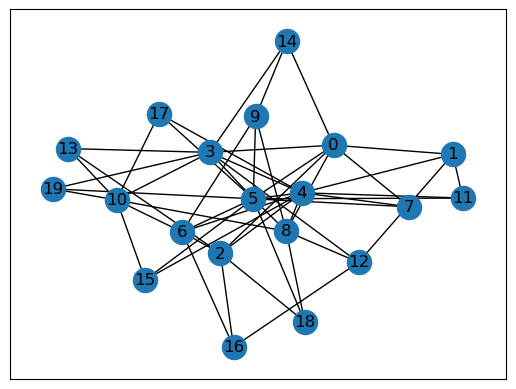

In [107]:
nx.draw_networkx(G)

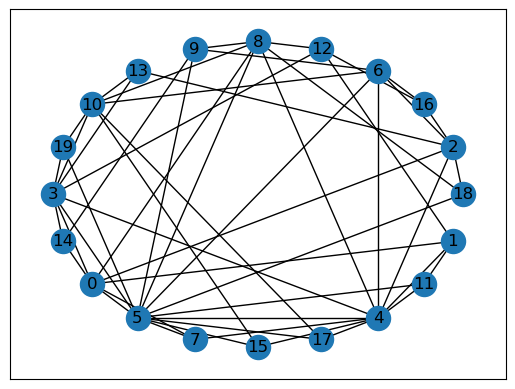

In [108]:
pos = graphviz_layout(G, prog="circo")
nx.draw_networkx(G, pos)
plt.show()

Our program fails to calculate the PageRank. Hence, we use the inbuilt function.

In [109]:
(P, t) = page_rank(G, .85)
P

/tmp/ipykernel_20046/3751517394.py:6: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G).A


{0: 0.06618243229346435,
 1: 0.04118425948246734,
 2: 0.05877219168498533,
 3: 0.07513993475061959,
 4: 0.09192045554989922,
 5: 0.10937635187889938,
 6: 0.05744400833276382,
 7: 0.03110384858041082,
 8: 0.06562253136959736,
 9: 0.04044956277996282,
 10: 0.06722439090704715,
 11: 0.031816238771584474,
 12: 0.041485809509929576,
 13: 0.0319754240848617,
 14: 0.0321170179348214,
 15: 0.03123327170187121,
 16: 0.032778544149041924,
 17: 0.03123327170187121,
 18: 0.03154121928538908,
 19: 0.031399235250512955}

In [110]:
t

14

In [111]:
Q, t = q_rank(G, .85)
Q

{0: 0.063,
 1: 0.0428,
 2: 0.0571,
 3: 0.0704,
 4: 0.0843,
 5: 0.0988,
 6: 0.0558,
 7: 0.0345,
 8: 0.0625,
 9: 0.0421,
 10: 0.064,
 11: 0.0352,
 12: 0.0431,
 13: 0.0354,
 14: 0.0356,
 15: 0.0346,
 16: 0.0362,
 17: 0.0346,
 18: 0.035,
 19: 0.0348}

In [112]:
t

12

In [113]:
P1 = np.real(list(P.values()))
P1

array([0.06618243, 0.04118426, 0.05877219, 0.07513993, 0.09192046,
       0.10937635, 0.05744401, 0.03110385, 0.06562253, 0.04044956,
       0.06722439, 0.03181624, 0.04148581, 0.03197542, 0.03211702,
       0.03123327, 0.03277854, 0.03123327, 0.03154122, 0.03139924])

In [114]:
Q1 = np.real(list(Q.values()))
Q1

array([0.063 , 0.0428, 0.0571, 0.0704, 0.0843, 0.0988, 0.0558, 0.0345,
       0.0625, 0.0421, 0.064 , 0.0352, 0.0431, 0.0354, 0.0356, 0.0346,
       0.0362, 0.0346, 0.035 , 0.0348])

In [115]:
X = list(G.nodes())
X

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]

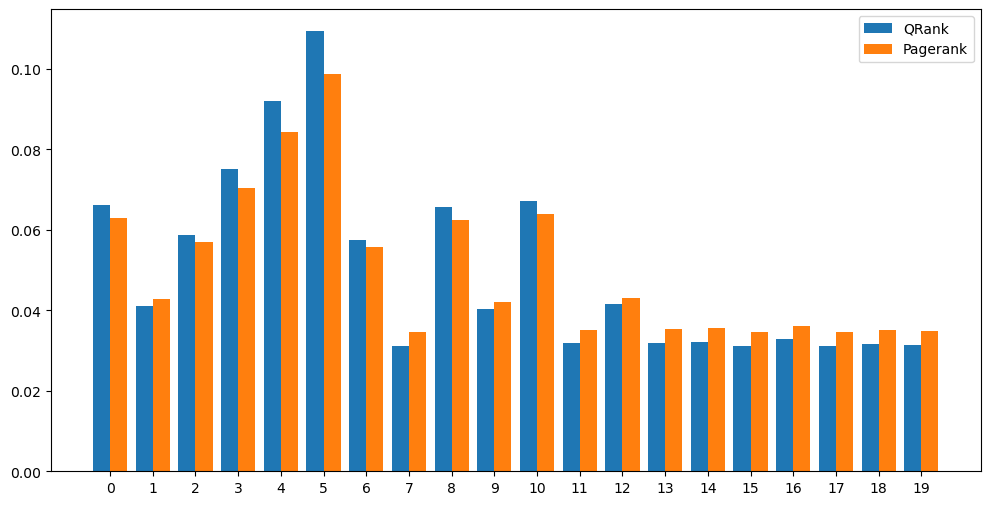

In [116]:
plt.figure(figsize=(12,6))
X_axis = np.arange(len(X))
plt.bar(X_axis - 0.2, P1, 0.4, label = 'QRank') 
plt.bar(X_axis + 0.2, Q1, 0.4, label = 'Pagerank')
plt.xticks(X_axis, X) 
plt.legend() 
plt.show() 